In [1]:
from xbbg import blp
import pdblp
import workdays
import datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

##### Getting BDP
LS = ["ES","NQ","RTY","VG","GX","Z ","PT","XP","TP","HI","XU","IH"]

T=[]
T1=[]
for i in range(len(LS)):
    T += [LS[i]+"A Index"]
    T1 += [LS[i]+"1 Index"]
    
BDP = blp.bdp(tickers=T, flds=["name","currency","undl_spot_ticker"])
BDP = BDP.loc[T,:]

BDP1 = blp.bdp(tickers=T1, flds=["volume_avg_5d","volatility_90d"])
BDP1 = BDP1.loc[T1,:]

undl = BDP.loc[T,["undl_spot_ticker"]].loc[T,:] + " Index"

tmp=[]
for i in range(len(undl)):
    tmp += [undl.iloc[i,0]]
tmp = blp.bdp(tickers=tmp, flds="country_iso").loc[tmp,"country_iso"]
BDP["country"] = BDP["name"]
for i in range(len(T)):
    BDP.loc[:,"country"][i] = tmp[i]
    
    undl = BDP.loc[T,["undl_spot_ticker"]].loc[T,:] + " Index"
tmp=[]
for i in range(len(undl)):
    tmp += [undl.iloc[i,0]]
tmp = blp.bdp(tickers=tmp, flds="country_iso").loc[tmp,"country_iso"]

for i in range(len(T)):
    BDP["country"][i] = tmp[i]
BDP["volume"] = BDP1["volume_avg_5d"].values
BDP["vola"] = BDP1["volatility_90d"].values
BDP["vola"] = round(BDP["vola"],1)
# BDP.index = LS
BDP.insert(0, "Ticker", LS)
BDP.index = list(range(0, len(BDP)))
BDP

,Ticker,name,currency,undl_spot_ticker,country,volume,vola
0,ES,S&P500 EMINI FUT Sep23,USD,SPX,US,1882416.0,14.3
1,NQ,NASDAQ 100 E-MINI Sep23,USD,NDX,US,560596.2,18.5
2,RTY,E-Mini Russ 2000 Sep23,USD,RTY,US,273865.2,21.7
3,VG,EURO STOXX 50 Jun23,EUR,SX5E,EU,1447616.4,16.2
4,GX,DAX INDEX FUTURE Jun23,EUR,DAX,DE,68583.0,15.3
5,Z,FTSE 100 IDX FUT Jun23,GBP,UKX,GB,255198.4,13.4
6,PT,S&P/TSX 60 IX FUT Jun23,CAD,SPTSX60,CA,77513.6,11.4
7,XP,SPI 200 FUTURES Sep23,AUD,AS51,AU,97747.4,11.3
8,TP,TOPIX INDX FUTR Sep23,JPY,TPX,JP,79638.6,14.7
9,HI,HANG SENG IDX FUT Jun23,HKD,HSI,HK,105121.2,22.9


In [2]:
##### Getting BDH
con = pdblp.BCon(timeout=5000)
con.start()

d_from = workdays.workday(datetime.datetime.today(), days=-260).strftime("%Y%m%d")
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime("%Y%m%d")

df = con.bdh(T1, ["px_last"], d_from, d_to).reset_index()
#df = con.bdh(T1, ["px_last"], d_from, d_to,elms = [("periodicitySelection","WEEKLY")]).reset_index() #Weekly

df = df[["date"]+T1]
df.columns = ["Date"]+LS

for j in range(0,len(LS)):    
    df[LS[j]+"_RetD"] = df[LS[j]].pct_change()
    
df.head()

,Date,ES,NQ,RTY,VG,GX,Z,PT,XP,TP,...,RTY_RetD,VG_RetD,GX_RetD,Z _RetD,PT_RetD,XP_RetD,TP_RetD,HI_RetD,XU_RetD,IH_RetD
0,2022-06-16,3789.49,11600.60,1701.54,3365.8,13201.15,7001.0,1149.57,6405.9,1814.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-17,3794.13,11745.65,1715.13,3366.7,13331.10,6950.5,1146.66,6310.7,1773.5,...,0.007987,0.000267,0.009844,-0.007213,-0.002531,-0.014861,-0.022542,0.012077,0.019415,0.000392
2,2022-06-20,NaN,NaN,NaN,3393.3,13468.52,7064.0,1162.51,6287.9,1771.6,...,0.000000,0.007901,0.010308,0.016330,0.013823,-0.003613,-0.001071,0.005658,0.006538,0.003036
3,2022-06-21,3889.10,12037.29,1744.28,3420.8,13506.19,7095.5,1166.02,6361.3,1804.2,...,0.016996,0.008104,0.002797,0.004459,0.003019,0.011673,0.018401,0.017066,0.000282,0.016957
4,2022-06-22,3883.94,12025.33,1742.22,3397.2,13373.85,7046.0,1153.58,6335.5,1801.3,...,-0.001181,-0.006899,-0.009798,-0.006976,-0.010669,-0.004056,-0.001607,-0.023008,-0.009776,-0.014435


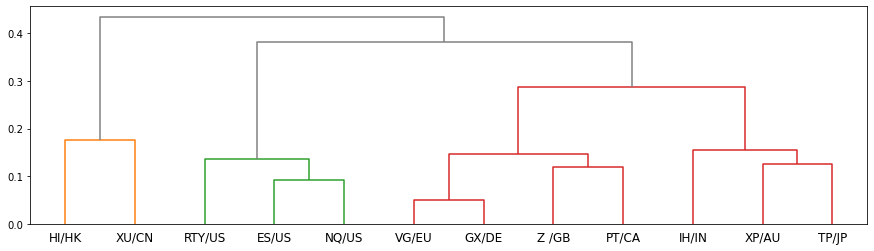

In [3]:
##### Cluster
LSC = []
for i in range(0,len(LS)):
    LSC += [LS[i] + "/" + BDP.loc[BDP["Ticker"]==LS[i],"country"].values[0] ]

tmp = [x + "_RetD" for x in LS]
df_Ret = df.loc[1:,tmp].reset_index(drop=True)

linkage_result = linkage(df_Ret.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 4))
dn = dendrogram(linkage_result, labels=list(LSC), above_threshold_color="grey")